## I -  Objet :

- Explorer les données et les mettre en forme par le biais de la dataviz.

## II - Pré-requis :

- Charger le df_vocals.

## III - Trame:

- Analyse de la durée des voix et du seuil audible.
- Etude de la distribution des styles.
- Vérification de la qualité des signaux.
- Etude qualitative de l'influence du rééchantillonnage.
- Choisir le bon format de spectrogramme.


## IV - Code :

###  IV.i - Bibliothèques requises:

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
import torch
import torchaudio
import re
import swifter
from IPython.display import Audio, display
from sklearn.metrics import classification_report

### IV.ii - Fonctions dédiées:

In [2]:
##############################################################################################################    
# Une fonction qui renvoie le dernier terme d'une string:
def style(x):
    r = re.compile(r"[A-Za-z0-9\-]+")
    liste = r.findall(x)
    
    key = liste[-1].lower()
    
    return key  

################################################################################################################
# Une fonction qui rajoute un zéro toutes les 4 valeurs d'une liste donnée:
def comp(liste):

    liste_2 = []
    for i,value in enumerate(liste):
        if i%2==0:
            liste_2.append(value)
            liste_2.append(0)
            liste_2.append(0)
            liste_2.append(0)
            
        if i%2!=0:
            liste_2.append(value)
            liste_2.append(0)
            liste_2.append(0)
            liste_2.append(0)
            
    return liste_2  


############################################################################################################
# la fonction qui crée des échantillons disjoints de nb_var features pour un signal donné:

def create_data_fast(signal,nb_var):
    
    ECH_mix = [[] for _ in range(nb_var)]                    

    for k in range(nb_var):                                  
        data=[]                                              
        for i in range(k,len(signal)-nb_var,nb_var):   
            data.append(signal[i:i+nb_var])              
        ECH_mix[k].append(data)                              
        if len (ECH_mix[k][0])>nb_var:
            ECH_mix[k][0]=ECH_mix[k][0][:-1] 
            
    return pd.DataFrame(ECH_mix[0][0])


##########################################################################################################
# la fonction qui produit le ratio audible / durée morceaux:

def ratio(signal_vocal):
    
    duree_total = len(signal_vocal)                                    # le nombre de valeur d'amplitude du morceau.
    seuil_vocal = np.where(abs(signal_vocal)> seuil,1,0)               # Si la valeur d'amplitude est au-dessus du seuil -> 1 sinon 0
    df_echantillon_seuil = create_data_fast(seuil_vocal,nb_var)        # Utilisation format Dataframe pour les seuils. 
    
    # On somme toutes les valeurs de seuil.
    df_echantillon_seuil['somme'] =  df_echantillon_seuil.sum(axis = 1)
    
    # Si la somme est nulle (i.e si aucune valeur n'est au dessus du seuil, alors on est en présence d'inaudible)
    # A l'inverse, si au moins une seule valeur est au dessus, alors on considère que le tronçon entier est constitutif d'un
    # passage audible.
    
    df_echantillon_seuil['label'] = df_echantillon_seuil['somme'].apply(lambda x : 0 if x ==0 else 1)
    
    silence = df_echantillon_seuil['label'][df_echantillon_seuil['label']==0]
    audible = df_echantillon_seuil['label'][df_echantillon_seuil['label']==1]
    return  len(audible)/ (len(audible)+len(silence))

### IV.iv - Variables clés

In [3]:
nb_var = 100   # Le nombre de pas temporel constitutifs de nos échantillons.
seuil = 0.01   # le seuil au delà duquel on considère qu'il y a voix.
fe = 44100     # la fréquence d'échantillonnage.

### IV.v - Développements

- On charge les dataframes vocals et mix.

In [4]:
Check = np.load('df_vocals.npy', allow_pickle=True )
Check2 = np.load('df_multi.npy', allow_pickle=True )
df_vocals = pd.DataFrame(Check,columns = ['id','Artiste_Morceau','Style','vocals'])
df_multi = pd.DataFrame(Check2,columns = ['id','Artiste_Morceau','Style','bass','drums','mixture','other','vocals'])

In [5]:
df_vocals

id                     Artiste_Morceau                      Style  \
0   051         AM Contra - Heart Peripheral       Electronic Dance Pop   
1   052                  ANiMAL - Easy Tiger                 UK Hip-Hop   
2   053              Actions - Devil s Words                  Power Pop   
3   054         Actions - South Of The Water                  Power Pop   
4   055   Angels In Amplifiers - I m Alright       Smooth Acoustic Rock   
..   ...                                 ...                        ...   
95  046                    Triviul - Dorothy  Leftfield Pop/Electronica   
96  047    Voelund - Comfort Lives In Belief       Laid-back Blues-Rock   
97  048       We Fell From The Sky - Not You     High-Energy Heavy Rock   
98  049                Young Griffo - Facade        Anthemic Heavy Rock   
99  050                         Zeno - Signs            Epic Indie Rock   

                                               vocals  
0   [0.0, -1.5258789e-05, 1.5258789e-05, 0.0, -1.5...  
1   [0.0, 0.0, -1.5258789e-05, 1.5258789e-05, -3.0...  
2   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.525...  
..                                                ...  
95  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
96  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
97  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
98  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
99  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[100 rows x 4 columns]

### -----------------------------------------------De la durée des voix et seuil de l'audible------------------------------------------------

Chaque signal vocal présente des zones où aucune voix n'est audible. Les valeurs d'amplitudes pour ces moments oscillent autour de zéro, sans être strictement nulles, comme on  peut le constater sur le graphique ci-dessous, qui illustre les valeurs d'amplitude de 5 % des canaux vocaux.

In [6]:
tout = df_vocals['vocals'].loc[0]

for i in df_vocals.index[1:5]:
    tout = np.concatenate([tout,df_vocals['vocals'].loc[i] ])

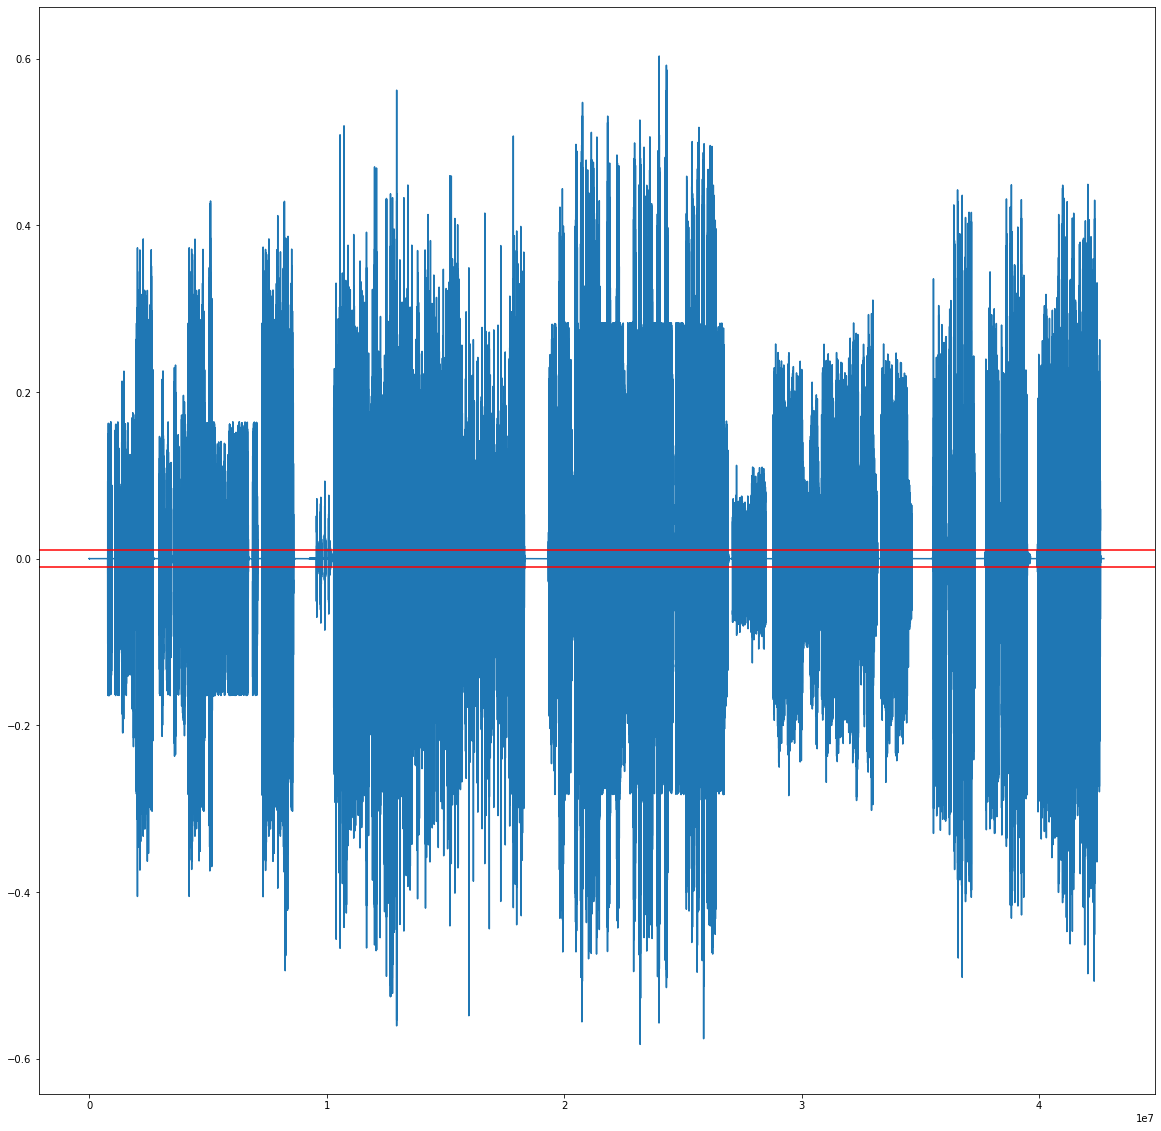

In [7]:
plt.figure(figsize =(20,20))
plt.plot(tout)
plt.axhline(y=0.01,color ='r')
plt.axhline(y=-0.01,color ='r')

plt.show()

On considère que les surépaisseurs du trait correspondent à des bruits parasites ou de la "respiration". On fixe ainsi "manuellement" le seuil à une valeur telle que les oscillations ne dépassent pas ce seuil.


On considère que les 5 % présentés ci-dessus sont représentatifs de l'ensemble des morceaux.

On souhaite à présent caractériser et distinguer les durées de voix audible  de celles des moments inaudibles et silences. Il ne serait pas juste de considérer chaque valeur d'amplitude prise séparemment, puisque quel que soit le moment observé (audible ou inaudible), il y aura des valeurs sous le seuil. Ceci est inhérent à la méthode d'échantillonnage, tel qu'illustré ci-dessous sur un tronçon de quelques secondes:

C:\Users\Utilisateur\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


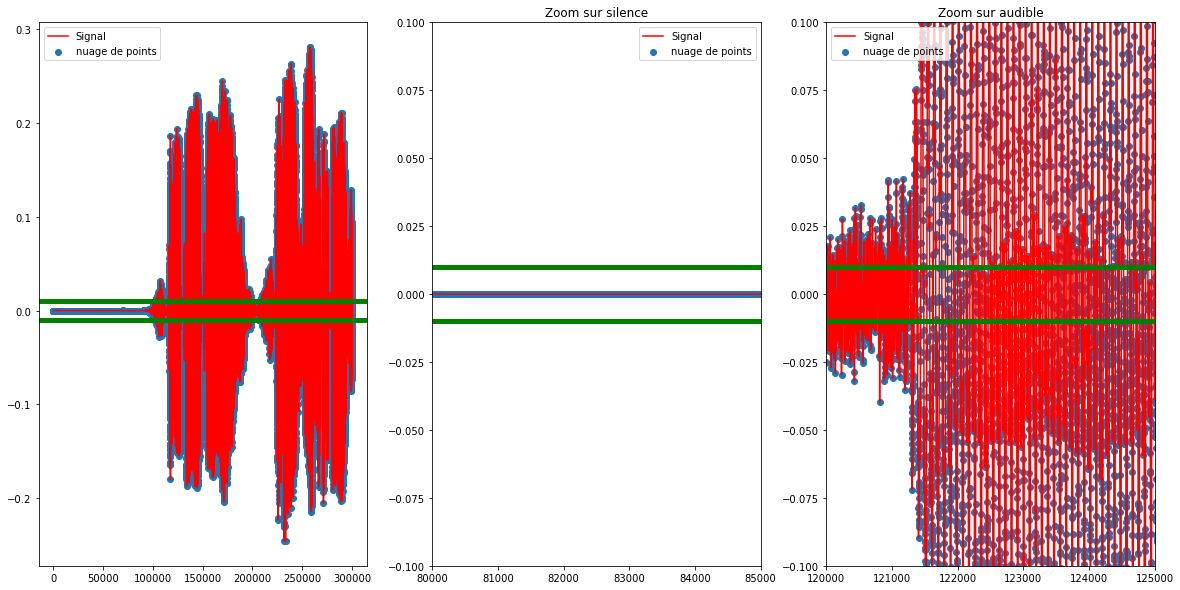

In [8]:
plt.figure(figsize=(20,10))
debut = 900000
fin = 1200000

plt.subplot(1,3,1)
plt.plot(df_vocals['vocals'].loc[2][debut:fin],'r',label = 'Signal')
plt.scatter([ i for i in range(len(df_vocals['vocals'].loc[2][debut:fin]))],df_vocals['vocals'].loc[2][debut:fin],label = 'nuage de points')
plt.axhline(y=0.01,color ='g',linewidth = 5)
plt.axhline(y=-0.01,color ='g',linewidth = 5)
plt.legend()

plt.subplot(1,3,2)
plt.plot(df_vocals['vocals'].loc[2][debut:fin],'r',label = 'Signal')
plt.scatter([ i for i in range(len(df_vocals['vocals'].loc[2][debut:fin]))],df_vocals['vocals'].loc[2][debut:fin],label = 'nuage de points')
plt.xlim(80000,85000)
plt.ylim(-0.1,0.1)
plt.title ('Zoom sur silence')
plt.axhline(y=0.01,color ='g',linewidth = 5)
plt.axhline(y=-0.01,color ='g',linewidth = 5)
plt.legend()

plt.subplot(1,3,3)
plt.plot(df_vocals['vocals'].loc[2][debut:fin],'r',label = 'Signal')
plt.scatter([ i for i in range(len(df_vocals['vocals'].loc[2][debut:fin]))],df_vocals['vocals'].loc[2][debut:fin],label = 'nuage de points')
plt.xlim(120000,125000)
plt.ylim(-0.1,0.1)
plt.title ('Zoom sur audible')
plt.axhline(y=0.01,color ='g',linewidth = 5)
plt.axhline(y=-0.01,color ='g',linewidth = 5)
plt.legend()

plt.show()

Le graphique de droite rend bien compte du fait qu'il existe des valeurs d'amplitudes inférieures au seuil prédéfini mais qui "participent" bien à la construction d'un signal audible.

Il serait plus pertinent de considérer des tronçons de musique de n pas de temps, et de classer ces tronçons en audible ou inaudible selon que, respectivement, au moins une valeur d'amplitude est au-dessus du seuil ou aucune valeur d'amplitude ne dépasse ce seuil.

Ensuite, faire un ratio entre les 2 classes puis appliquer ce ratio à la durée totale du morceau pour en déduire la durée audible.

L'ensemble de ces étapes sont regroupées dans la fonction "ratio" qui prend une liste de valeur d'amplitudes en entrée et produit le ratio décrit précédemment.

- Questions pertinentes à se poser :
    - Q1: Combien de pas temporel devons-nous considérer pour l'analyse ?
    - Q2: Quel seuil alors retenir ?

- Réponse Q1: le nombre minimal nécessaire et suffisant pour qu'il y ait oscillation, i.e considérer l'équivalent d'une période.

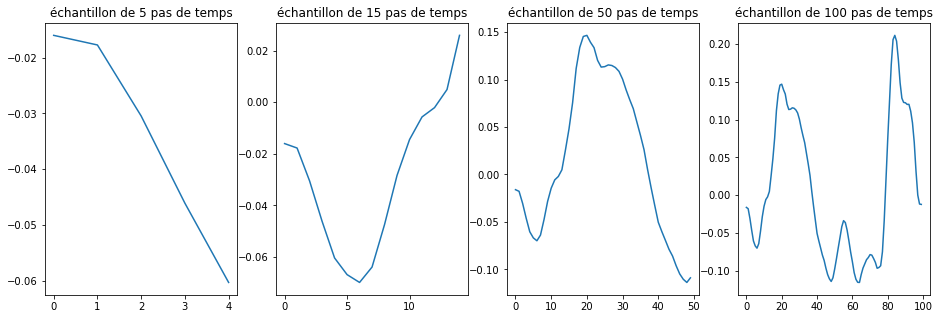

In [9]:
# On affiche des tronçons de signaux constitués de valeurs croissantes de nombre de pas temporels.
plt.figure(figsize=(20,5))

plt.subplot(1,5,1)
plt.plot(df_vocals['vocals'].loc[0][2000000:2000000+5])
plt.title ('échantillon de 5 pas de temps')

plt.subplot(1,5,2)
plt.plot(df_vocals['vocals'].loc[0][2000000:2000000+15])
plt.title ('échantillon de 15 pas de temps')

plt.subplot(1,5,3)
plt.plot(df_vocals['vocals'].loc[0][2000000:2000000+50])
plt.title ('échantillon de 50 pas de temps')

plt.subplot(1,5,4)
plt.plot(df_vocals['vocals'].loc[0][2000000:2000000+100])
plt.title ('échantillon de 100 pas de temps')

plt.show()

Il semble ainsi correct de considérer 100 pas temporels pour l'analyse.

- Réponse Q2 : On prend le parti de conserver le seuil macroscopique.

 On applique à l'ensemble des morceaux de la base (cela prend environ 25 min):

In [10]:
df_vocals['ratio'] = df_vocals['vocals'].swifter.apply(lambda x: ratio(x))

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

In [11]:
df_vocals

id                     Artiste_Morceau                      Style  \
0   051         AM Contra - Heart Peripheral       Electronic Dance Pop   
1   052                  ANiMAL - Easy Tiger                 UK Hip-Hop   
2   053              Actions - Devil s Words                  Power Pop   
3   054         Actions - South Of The Water                  Power Pop   
4   055   Angels In Amplifiers - I m Alright       Smooth Acoustic Rock   
..   ...                                 ...                        ...   
95  046                    Triviul - Dorothy  Leftfield Pop/Electronica   
96  047    Voelund - Comfort Lives In Belief       Laid-back Blues-Rock   
97  048       We Fell From The Sky - Not You     High-Energy Heavy Rock   
98  049                Young Griffo - Facade        Anthemic Heavy Rock   
99  050                         Zeno - Signs            Epic Indie Rock   

                                               vocals     ratio  
0   [0.0, -1.5258789e-05, 1.5258789e-05, 0.0, -1.5...  0.638638  
1   [0.0, 0.0, -1.5258789e-05, 1.5258789e-05, -3.0...  0.851501  
2   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  0.812630  
3   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  0.875745  
4   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.525...  0.621738  
..                                                ...       ...  
95  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  0.849345  
96  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  0.647696  
97  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  0.486448  
98  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  0.571164  
99  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  0.596544  

[100 rows x 5 columns]

On affiche un premier graphique qui rend compte de la distribution des ratios pour l'ensemble des morceaux et un second graphique qui rend compte du ratio propre à chaque morceau.

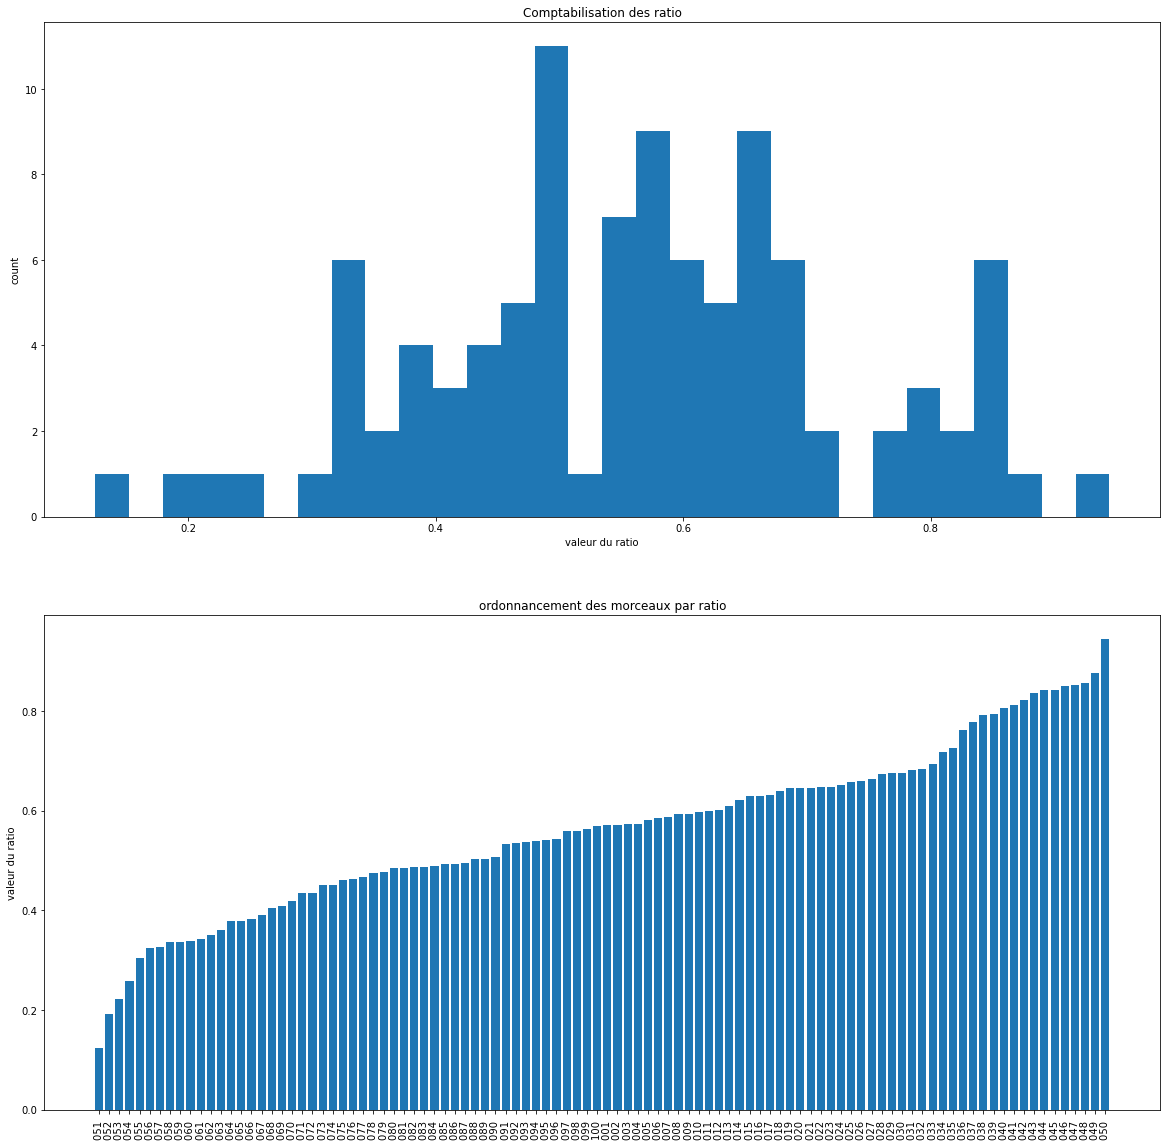

In [12]:
plt.figure(figsize=(20,20))

plt.subplot(2,1,1)
plt.hist(df_vocals.ratio,bins = 30)
plt.xlabel('valeur du ratio')
plt.ylabel('count')
plt.title('Comptabilisation des ratio')

plt.subplot(2,1,2)
plt.bar(df_vocals.id,df_vocals.ratio.sort_values())
plt.xticks(rotation='vertical')
plt.ylabel('valeur du ratio')
plt.title('ordonnancement des morceaux par ratio')


plt.show()

### -------------------------------------------- Des styles, des artistes  et des genres-----------------------------------------------------

Concernant les artistes et leurs oeuvres:

In [13]:
print(f"le jeu de donnée porte bien sur {df_vocals.Artiste_Morceau.unique().size} morceaux de musique interprétés par {df_vocals.Artiste_Morceau.apply(lambda x: x.split('-')[0]).unique().size} artistes différents.")

le jeu de donnée porte bien sur 100 morceaux de musique interprétés par 76 artistes différents.


Combien d'artistes chantent 1,2,3,...,n chansons ?:

In [14]:
oeuvre = df_vocals.copy()
oeuvre['Artiste'] =oeuvre.Artiste_Morceau.apply(lambda x: x.split('-')[0])
oeuvre['Morceau'] =oeuvre.Artiste_Morceau.apply(lambda x: x.split('-')[1])

df_agg=oeuvre.groupby('Artiste')['Morceau'].count().reset_index()

ratio = pd.DataFrame({'Nb chanson':df_agg['Morceau'].value_counts().index,'nb Artiste':df_agg['Morceau'].value_counts().values,'Percent':100*df_agg['Morceau'].value_counts().values/len(df_agg)})
ratio = ratio.set_index('Nb chanson')
ratio

nb Artiste    Percent
Nb chanson                       
1                   60  78.947368
2                    9  11.842105
3                    6   7.894737
4                    1   1.315789

Quelle est la distribution de la durée des morceaux ? (durée affichée en seconde)

In [15]:
oeuvre['duree'] = oeuvre['vocals'].apply(lambda x : round(len(x)/fe))
oeuvre['duree'].describe()

count    100.000000
mean     251.910000
std       59.887453
min      142.000000
25%      209.500000
50%      247.000000
75%      279.000000
max      435.000000
Name: duree, dtype: float64

Quelle est la distribution des styles ?

In [16]:
df_vocals.Style.value_counts()

Acoustic Singer-Songwriter    6
Atmospheric Indie Pop         4
UK Hip-Hop                    3
Leftfield Pop/Electronica     3
Indie Pop/Rock                3
                             ..
Alternative Rock Ballad       1
Classic Psychedelic Rock      1
Bubblegum Pop                 1
Acoustic Indie Pop            1
Pop Disco/Rock                1
Name: Style, Length: 65, dtype: int64


Une quantité importante de style apparemment disjoints sont présents. Néanmoins, quelques termes reviennent  fréquemment. On simplifie la liste en conservant le dernier terme du style :
 
 


In [17]:
df_vocals['genre'] = df_vocals['Style'].apply(lambda x : style(x))
df_vocals.genre = df_vocals.genre.replace(['electronica','punk-rock','art-punk','blues-rock'],['electro','punk','punk','rock'])

On procède à l'analyse visuelle sur les styles:

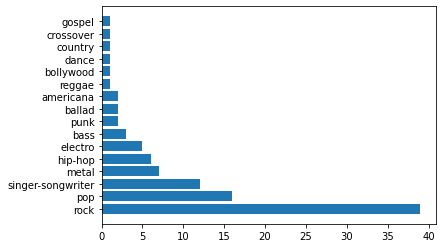

In [18]:
plt.barh(df_vocals.genre.value_counts().index,df_vocals.genre.value_counts().values )
plt.show()

Le nombre de style a été divisé par 4. La nouvelle présentation, sans doute critiquable par les mélomanes, a le mérite de clarifier la situation

Quelle est la distribution des durées en fonction des nouveaux styles identifiés ?

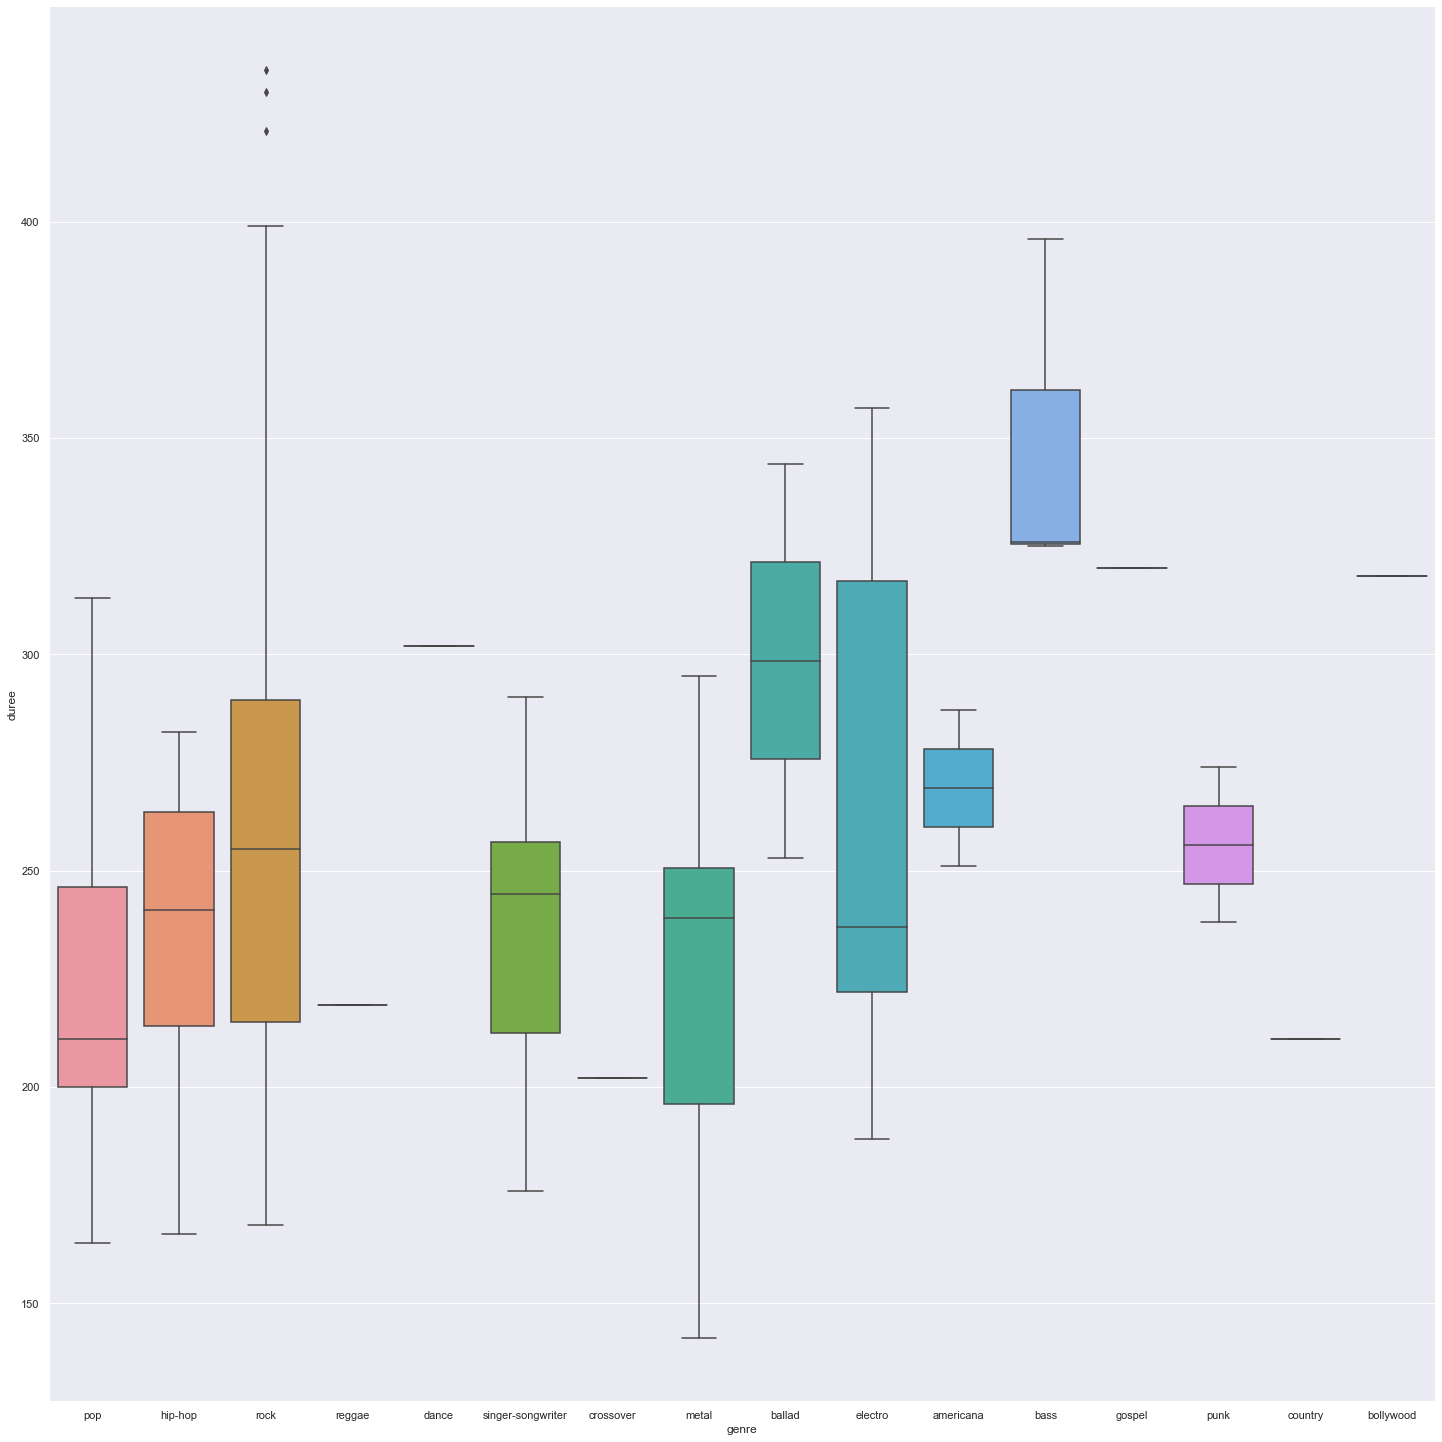

In [19]:
df_vocals['duree'] = df_vocals['vocals'].apply(lambda x : round(len(x)/fe))
sns.set(rc = {'figure.figsize':(10,10)})
sns.catplot(x='genre',y = 'duree',kind = 'box', data = df_vocals,height = 20)
#plt.xticks(rotation ='vertical')

### --------------------------------------------------------Des signaux propres----------------------------------------------------------

- On vérifie que la somme des signaux restitue le signal mix complet :

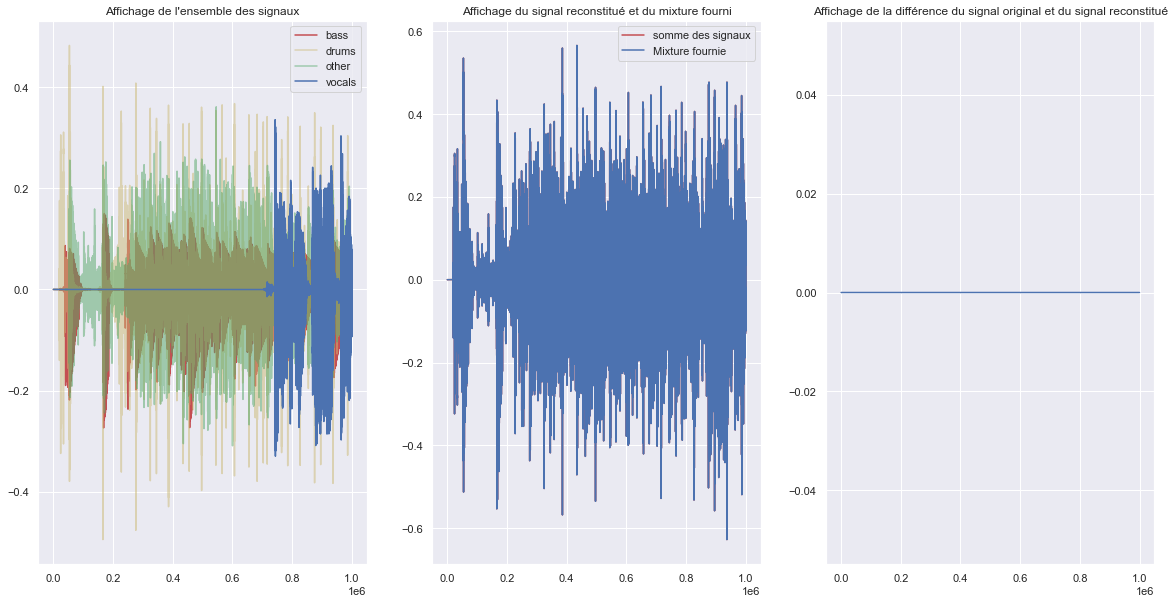

In [20]:
plt.figure(figsize = (20,10))

somme = df_multi.loc[4,'bass'][0:1000000] + df_multi.loc[4,'drums'][0:1000000] + df_multi.loc[4,'other'][0:1000000] + df_multi.loc[4,'vocals'][0:1000000]

plt.subplot(1,3,1)
plt.plot(df_multi.loc[4,'bass'][0:1000000],'r',label = 'bass')
plt.plot(df_multi.loc[4,'drums'][0:1000000],'y',alpha = 0.5,label = 'drums')
plt.plot(df_multi.loc[4,'other'][0:1000000],'g',alpha = 0.5,label = 'other')
plt.plot(df_multi.loc[4,'vocals'][0:1000000],'b',label = 'vocals')
plt.legend()
plt.title("Affichage de l'ensemble des signaux")

plt.subplot(1,3,2)

plt.plot(somme,'r',label = 'somme des signaux')
plt.plot(df_multi.loc[4,'mixture'][0:1000000],'b',label = 'Mixture fournie')
plt.legend()
plt.title("Affichage du signal reconstitué et du mixture fourni")

plt.subplot(1,3,3)

plt.plot(somme -df_multi.loc[4,'mixture'][0:1000000],'b')
plt.title("Affichage de la différence du signal original et du signal reconstitué")
plt.show()

 - On vérifie que cela est le cas pour l'ensemble des morceaux :

In [21]:
df_multi['verif'] = df_multi['bass'] + df_multi['drums'] + df_multi['other'] + df_multi['vocals'] - df_multi['mixture']
df_multi['ecart_au_zero'] = df_multi['verif'].apply(lambda x: sum(abs(x))/len(x))

In [22]:
df_multi['ecart_au_zero'].value_counts()


3.198373e-05    1
4.256645e-07    1
7.601696e-07    1
4.335446e-08    1
2.085087e-08    1
1.715443e-09    1
5.768776e-09    1
6.666141e-09    1
2.105768e-09    1
5.536651e-09    1
Name: ecart_au_zero, dtype: int64

Les valeurs ci-dessus rendent compte de l'écart moyen au zero de chaque valeur du signal, propre à chaque signal. On peut ainsi considérer que la différence terme à terme est nulle pour chaque valeur et qu'il y a ainsi bien quasi-parfaite correspondance.

### ------------------------------------------------ De l'influence du rééchantillonnage ---------------------------------------------------    

- On s'intéresse à l'écart qualitatif entre un signal échantilloné à 44100 Hz et le même signal échantilloné à 11025 Hz :

In [23]:
# Re-échantillonnage  par Torchaudio.
transform = torchaudio.transforms.Resample (44100, 11025, resampling_method = 'kaiser_window',lowpass_filter_width = 128)

# On crée les échantillons d'analyse.
signal_44100 = df_multi.loc[4,'mixture'][0:1000000]
signal_11025 = transform(torch.from_numpy(signal_44100)).numpy()

# On rajoute des zéros entre chaque valeur de sorte à pouvoir comparer l'original et l'échantillonné.
signal_11025_comparatif = np.array(comp(list(signal_11025))) 


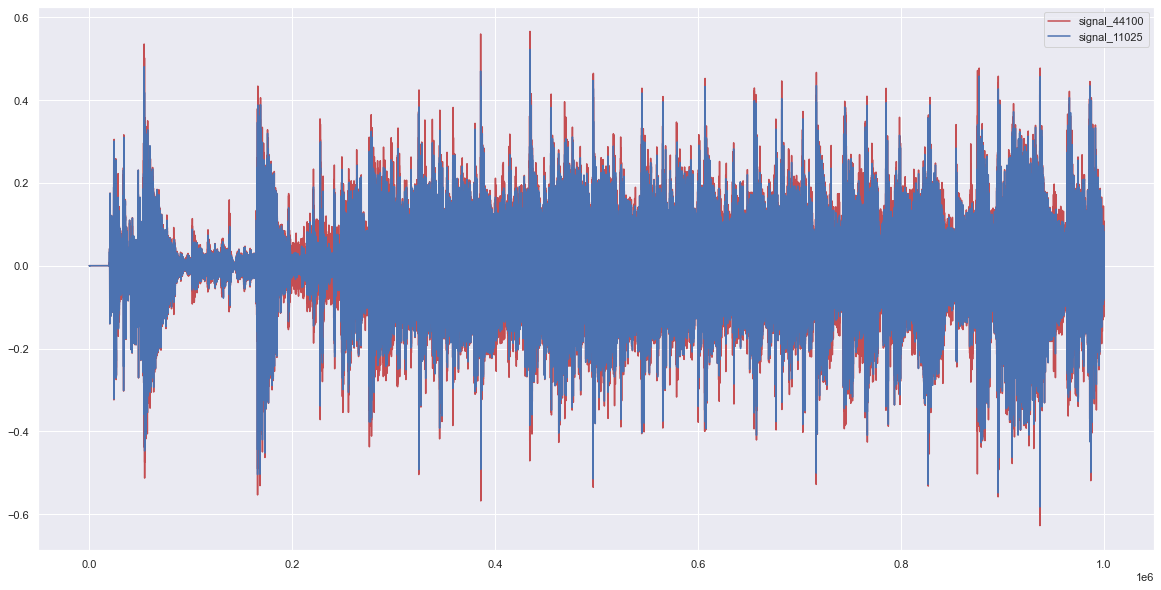

In [24]:
# On affiche le graphique d'analyse.

plt.figure(figsize = (20,10))

plt.plot(signal_44100,'r',label = 'signal_44100')
plt.plot(signal_11025_comparatif,'b',label = 'signal_11025')
plt.legend()
plt.show()




In [25]:
# On écoute le signal ré-échantillonné à 11025 Hz.
Audio (signal_11025,rate =11025)

In [26]:
# On écoute le signal original à 44100 Hz.
Audio (signal_44100,rate =44100)

In [27]:
# On écoute le signal ré-échantillonné à 11025 Hz auquel on rajoute une valeur d'amplitude à zéro entre chaque valeur d'amplitude
Audio (signal_11025_comparatif,rate =44100)

In [28]:
from sklearn.metrics import mean_squared_error

mean_squared_error(signal_11025_comparatif, signal_44100)

0.0055395724572064415

### -------------------------------------------------- Du choix des spectrogrammes -------------------------------------------------------     

- On s'intéresse aux spectrogrammes

In [29]:
# On prépare le calcul et l'affichage, pour un morceau complet de la base de re-éch Torch:
     # un spectrogramme.
     # un MEL sans regroupement de fréquence.
     # un MEL avec regroupement en 128 bins de fréquence

# Pour l'affichage du spectrogramme

def spectro(signal):
    %matplotlib inline
    n_fft = 1024 
    hop_length = 256
    D = np.abs(librosa.stft(signal, n_fft=n_fft, hop_length=hop_length))
    plt.figure(figsize=(17,5))
    DB = librosa.amplitude_to_db(D, ref=np.min)
    librosa.display.specshow(DB, hop_length=hop_length, x_axis='time', y_axis='mel', htk=True, cmap='coolwarm')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel ('time', fontsize=13)
    plt.ylabel ('mels', fontsize=13)
    plt.show();


# Pour l'affichage du MEL sans regroupement

def MEL (signal, fe = 11025, n_fft=1024, hop_length=256):
   
    %matplotlib inline

    D = np.abs(librosa.stft(signal, n_fft=n_fft, hop_length=hop_length))
    
    db = librosa.amplitude_to_db(D, ref=np.min) 

    plt.figure(figsize=(17,5))
    librosa.display.specshow(db, sr=fe, hop_length=hop_length, x_axis='time', y_axis='mel', htk=True, cmap='coolwarm')

    plt.colorbar(format='%+2.0f dB')
    plt.xlabel ('Time', fontsize=13)
    plt.ylabel ('mels', fontsize=13)
    plt.show();

# Pour l'affichage du MEL avec regroupement en 128 canaux, puissance en dB

def MEL_filters (signal, fe = 11025, n_fft=1024, hop_length=256):
   
    %matplotlib inline

    S = librosa.feature.melspectrogram (signal, sr=fe , n_fft=n_fft, hop_length=hop_length, n_mels=128)
    
    S_db =librosa.power_to_db(S, ref=np.min) 
 

    plt.figure(figsize=(17,5))
    librosa.display.specshow(S_db, hop_length=hop_length, x_axis='time', y_axis='mel', htk=True, cmap='coolwarm')

    plt.colorbar(format='%+2.0f dB')
    plt.xlabel ('Time', fontsize=13)
    plt.ylabel ('mels', fontsize=13)
    plt.show() ;


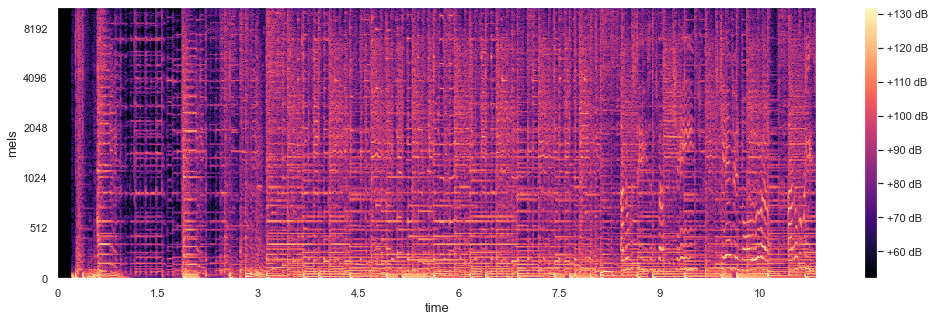

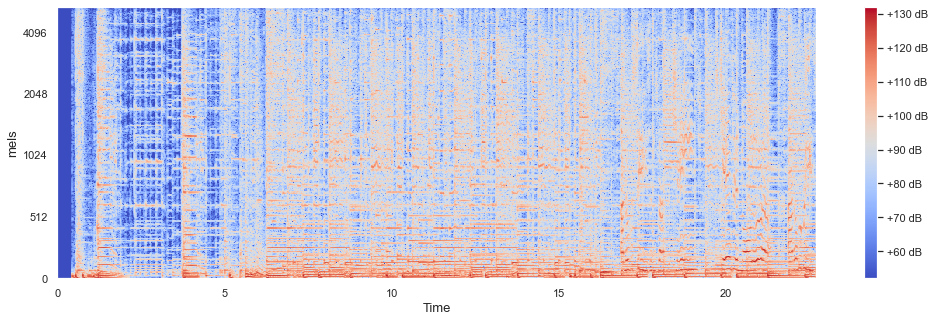

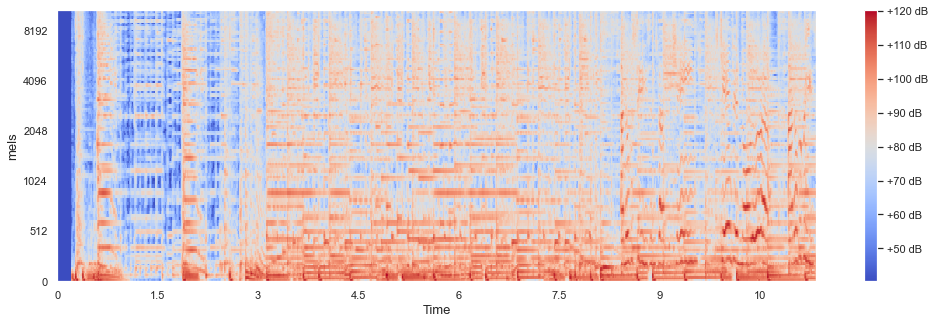

In [30]:
# On affiche les 3 spectrogrammes pour un morceau re-échantilloné selon Torchaudio:

plt.figure(figsize =(10,10))

plt.subplot(311)
spectro(signal_11025)

plt.subplot(312)
MEL(signal_11025,fe = 11025, n_fft=1024, hop_length=256)

plt.subplot(313)
MEL_filters(signal_11025,fe = 11025, n_fft=1024, hop_length=256)

Bien que présentant un meilleur contraste, le retroMEL avec regroupement de fréquence pose la question du retour vers le signal audio et la complexité induite par le fait que la matrice de passage de 513 à 128 pas de fréquence n'est pas inversible. On choisi de mettre en oeuvre une démarche où l'appréciation finale sera faite par l'écoute